In [2]:
if 'already_executed' not in globals():
    already_executed = False

if not already_executed:
    import os
    os.chdir("../")
    %load_ext autoreload
    %autoreload 2
    already_executed = True

In [3]:
from copy import deepcopy
import numpy as np
from typing import Optional
from sklearn.preprocessing import StandardScaler
from src.pricers.abstract_pricer import PricerAbstract
from src.samplers.abstract_sampler import SamplerAbstract


import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [21]:
from src.samplers.geometric_brownian_motion_put_sampler import GeometricBrownianMotionPutSampler
sampler = GeometricBrownianMotionPutSampler(**{
    "asset0": 100.0,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 60,
    "seed": None, 
    "cnt_trajectories": 1_000_000
})

# LSPI

In [5]:
from dataclasses import dataclass
@dataclass 
class A:
    _: int

self = A(0)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    n_paths, n_times, state_dim = markov_state.shape
    T = time_grid[-1]
    
    # Нормализованное время до экспирации
    time_to_exp = (T - time_grid) / T
    time_to_exp = np.tile(time_to_exp, (n_paths, 1))[..., None]
    
    # Объединяем время и состояние
    features = np.concatenate([time_to_exp, markov_state], axis=-1)
    flat_features = features.reshape(-1, features.shape[-1])
    
    # Первый вызов - инициализируем и фитим трансформеры
    if not self.is_fitted_:
        self.scaler_ = StandardScaler()
        self.poly_ = PolynomialFeatures(degree=self.degree, include_bias=True)
        
        scaled = self.scaler_.fit_transform(flat_features)
        poly_features = self.poly_.fit_transform(scaled)
        self.n_features_ = poly_features.shape[1]
        self.is_fitted_ = True
    else:
        # Используем обученные трансформеры
        scaled = self.scaler_.transform(flat_features)
        poly_features = self.poly_.transform(scaled)
    
    return poly_features.reshape(n_paths, n_times, -1)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    M = markov_state[:, :, 0] / 100.
    exp_term = np.exp(-M / 2.0)
    T = time_grid[-1]
    t = time_grid

    phi = np.zeros((*markov_state[:, :, 0].shape, 7), dtype = float)
    phi[:, :, 0] = 1.0
    phi[:, :, 1] = exp_term
    phi[:, :, 2] = exp_term * (1.0 - M)
    phi[:, :, 3] = exp_term * (1.0 - 2.0 * M + 0.5 * M * M)
    phi[:, :, 4] = np.sin(np.pi * (T - t) / (2.0 * T))
    phi[:, :, 5] = np.log(np.maximum(T - t, 1e-10)) # 1e-10 чтобы не было log(0)
    phi[:, :, 6] = (t / T) ** 2

    scaler = StandardScaler()
    phi_reshaped = phi[:, :, 1:].reshape(-1, 6)
    phi_scaled = scaler.fit_transform(phi_reshaped)
    phi_scaled = phi_scaled.reshape(phi.shape[0], phi.shape[1], 6)


    phi_final = np.zeros_like(phi)
    phi_final[:, :, 0] = phi[:, :, 0]
    phi_final[:, :, 1:] = phi_scaled

    return phi_final

In [6]:
self.sampler = sampler
self.sampler.sample()

GBM sampling:   0%|          | 0/29 [00:00<?, ?it/s]

In [27]:
r = -np.log(self.sampler.discount_factor[0, 1] / self.sampler.discount_factor[0, 0]) / (self.sampler.time_deltas[0])
self.dt = sampler.time_deltas[0]
self.is_fitted_ = False
self.degree = 3
self.iterations = 100
self.tol = 1e-6
self.reg_alpha = 1e-2
quiet = False

In [28]:
# Параметры
n_paths, n_times, _ = self.sampler.markov_state.shape
gamma = np.exp(-r * self.dt)  # Коэффициент дисконтирования

# Создаем признаки
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
n_features = phi_all.shape[-1]


w = np.zeros(n_features)

# Подготовка данных
phi_curr = phi_all[:, :-1, :]  # Текущие состояния (t)
phi_next = phi_all[:, 1:, :]    # Следующие состояния (t+1)
payoff_next = self.sampler.payoff[:, 1:]  # Выплаты в t+1

# Выравнивание в 1D
phi_curr_flat = phi_curr.reshape(-1, n_features)
phi_next_flat = phi_next.reshape(-1, n_features)
payoff_next_flat = payoff_next.reshape(-1)

# Флаг нетерминальных состояний
non_terminal = np.tile(
    np.arange(n_times-1, dtype=int) < n_times-2, 
    (n_paths, 1)
)
non_terminal_flat = non_terminal.reshape(-1)

# Итерации LSPI
for it in tqdm(range(self.iterations), desc="LSPI iterations"):
    prev_w = deepcopy(w)
    
    # Вычисляем Q-значения продолжения
    Q_cont_next = phi_next_flat @ w
    
    # Условие продолжения
    continue_cond = non_terminal_flat & (Q_cont_next >= payoff_next_flat)
    
    # Формируем систему уравнений
    diff_phi = phi_curr_flat - gamma * continue_cond[:, None] * phi_next_flat
    A = phi_curr_flat.T @ diff_phi
    b = gamma * phi_curr_flat.T @ ((~continue_cond) * payoff_next_flat)

    if self.reg_alpha is not None:
        A += np.eye(A.shape[0]) * self.reg_alpha
    w = np.linalg.solve(A, b)
    
    # Проверка сходимости
    diff_norm = np.linalg.norm(w - prev_w)
    if not quiet:
        print(f"Iteration {it}: ||Δw|| = {diff_norm:.9f}")
    if diff_norm < self.tol:
        if not quiet:
            print(f"Converged after {it} iterations")
        break

self.w = w

LSPI iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: ||Δw|| = 1020.417420331
Iteration 1: ||Δw|| = 1899.108230740
Iteration 2: ||Δw|| = 258.161517921
Iteration 3: ||Δw|| = 170.826358337


KeyboardInterrupt: 

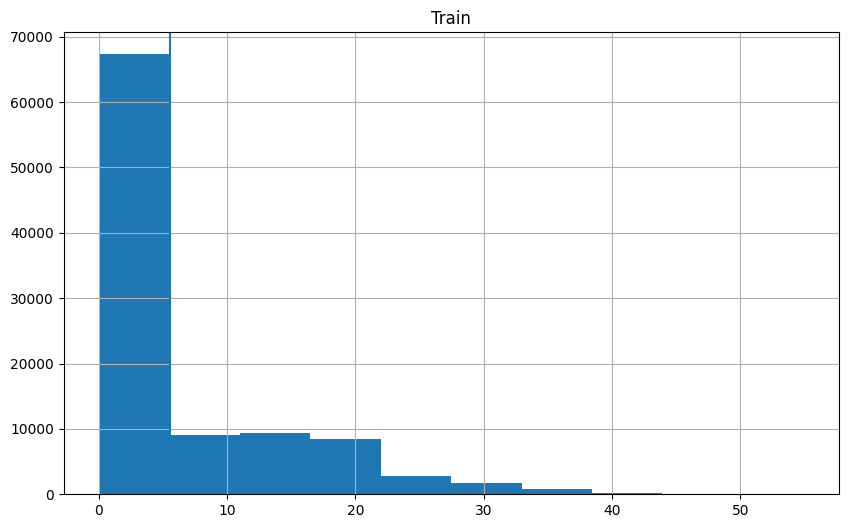

np.float64(5.569708347216534)

In [ ]:
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

plt.figure(figsize=(10, 6))
plt.hist(pv_payoffs)
plt.axvline(mean)
plt.title("Train")
plt.grid()
plt.show()
mean

In [ ]:
self.sampler.sample()

GBM sampling:   0%|          | 0/364 [00:00<?, ?it/s]

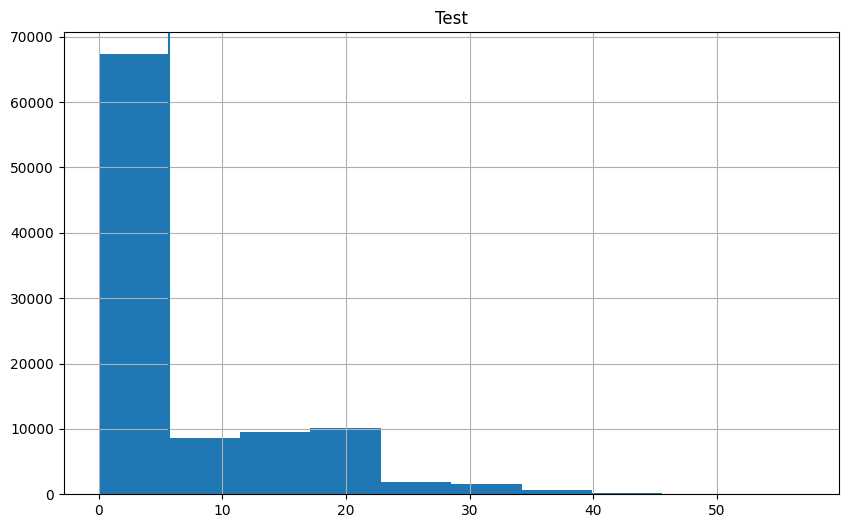

np.float64(5.658729837583071)

In [10]:
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

plt.figure(figsize=(10, 6))
plt.hist(pv_payoffs)
plt.axvline(mean)
plt.title("Test")
plt.grid()
plt.show()
mean

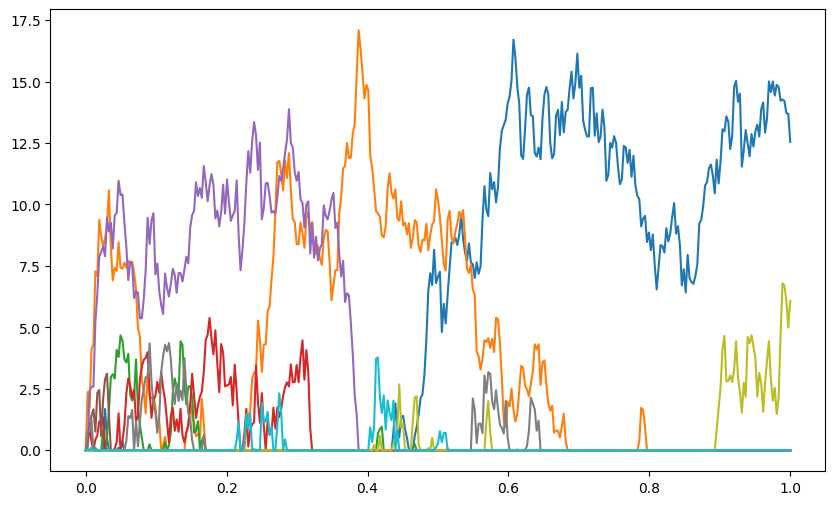

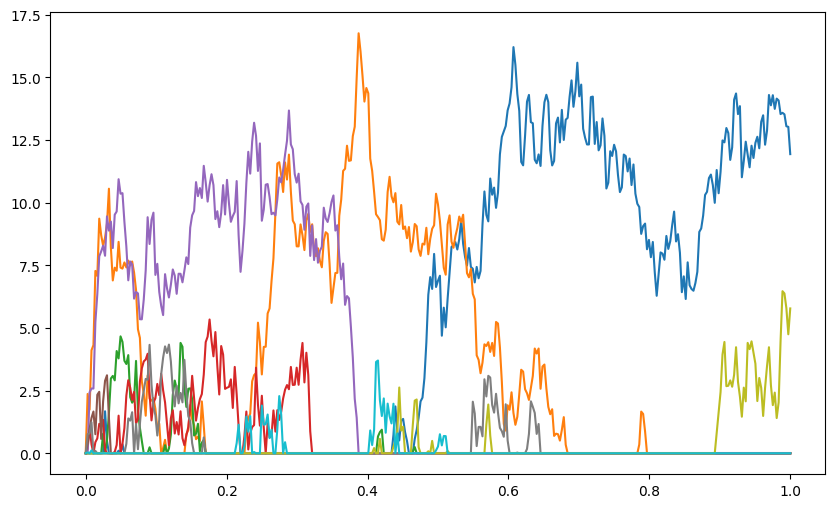

In [ ]:
n_traj = 10

plt.figure(figsize=(10, 6))
plt.plot(self.sampler.time_grid, self.sampler.payoff[:n_traj, :].T)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(self.sampler.time_grid, (self.sampler.payoff[:, :] * self.sampler.discount_factor)[:n_traj, :].T)
plt.show()

# LSMC

AMC price train:  98%|#########8| 58/59 [00:11<00:00,  4.99it/s]

/home/jovyan/vorobiov/AmericanOptionsPricingApproaches/src/pricers/american_monte_carlo.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


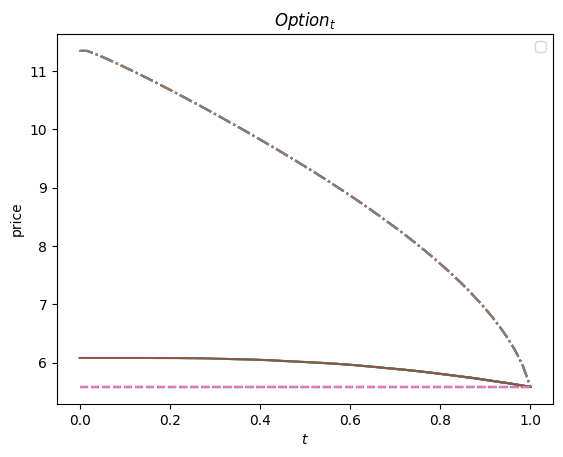

In [22]:
from src.pricers.american_monte_carlo import AmericanMonteCarloPricer
pricer = AmericanMonteCarloPricer(sampler, degree=3)
pricer.price();
pricer.result

  0%|          | 0/60 [00:00<?, ?it/s]

None


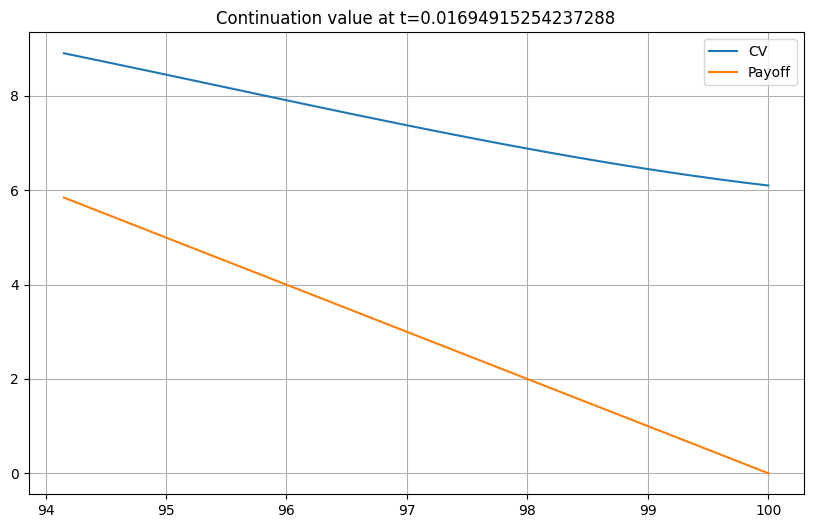

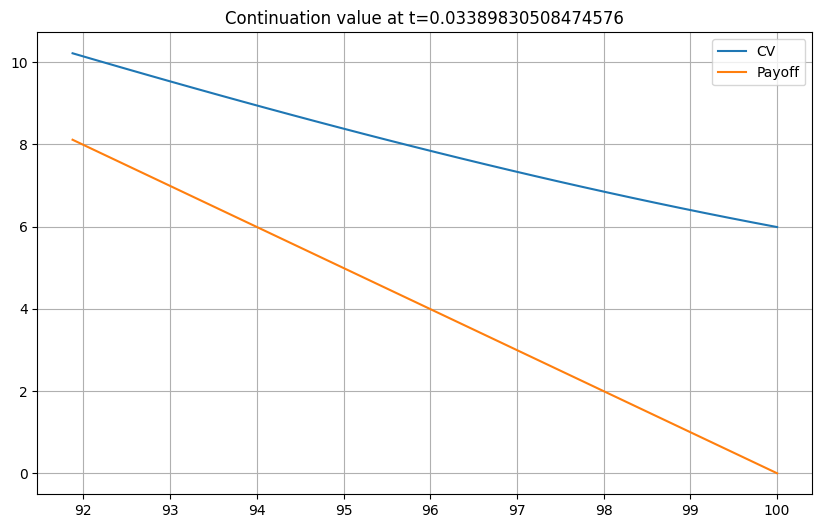

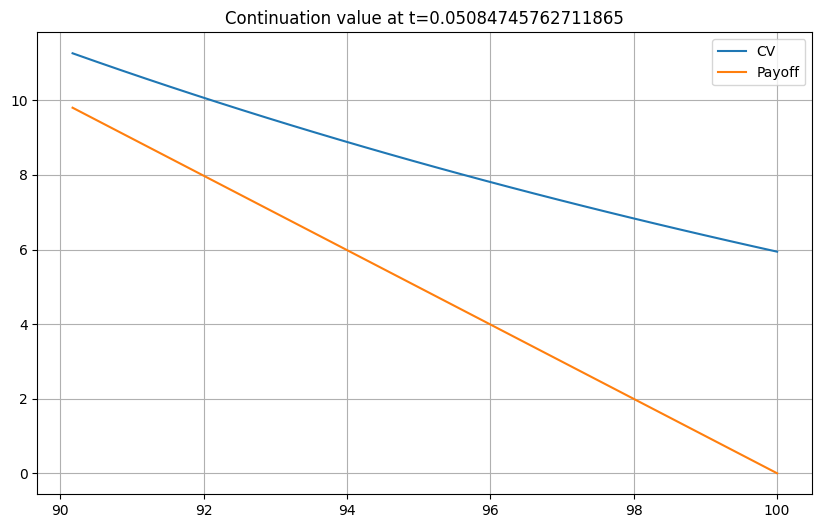

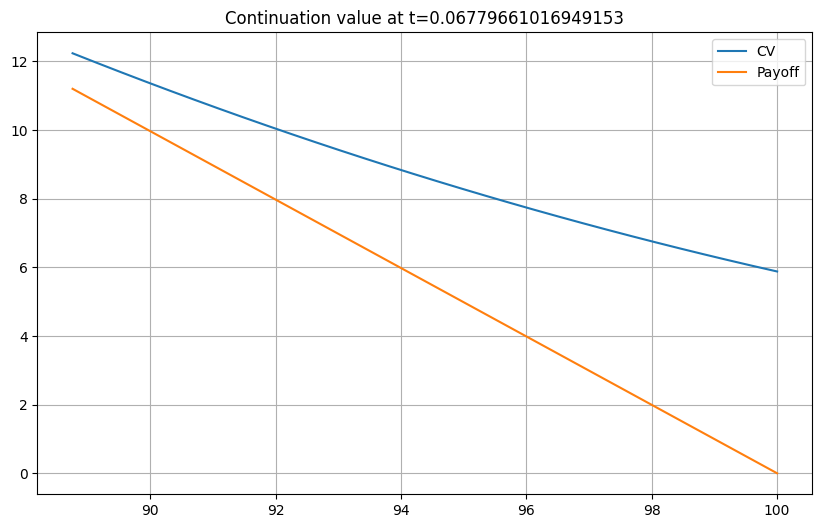

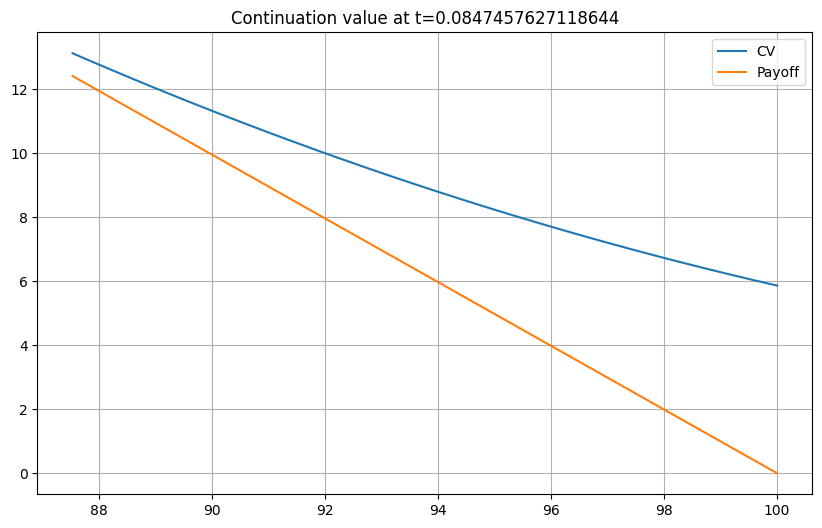

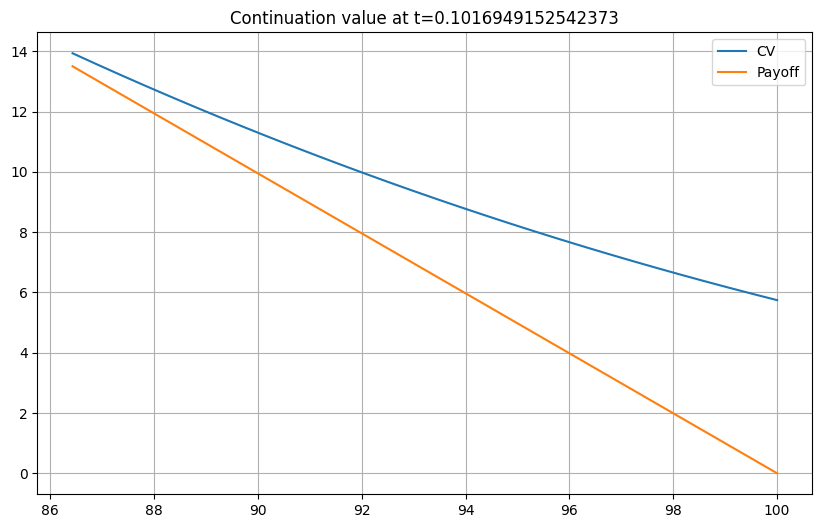

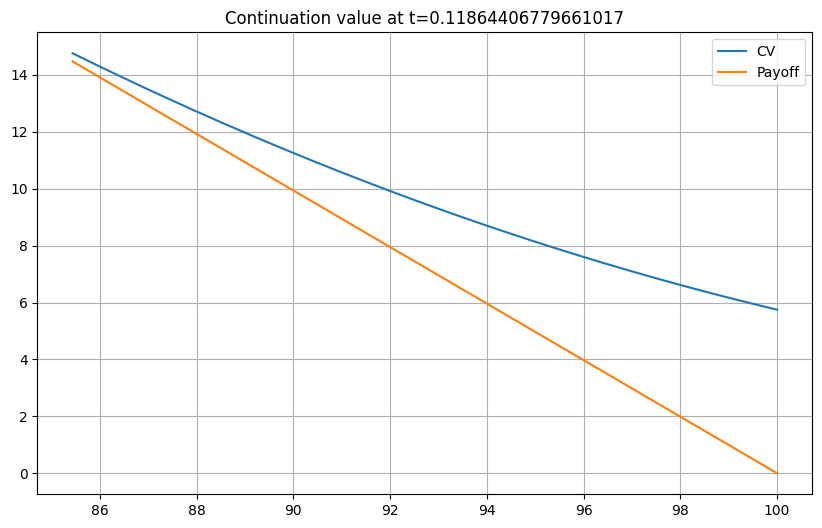

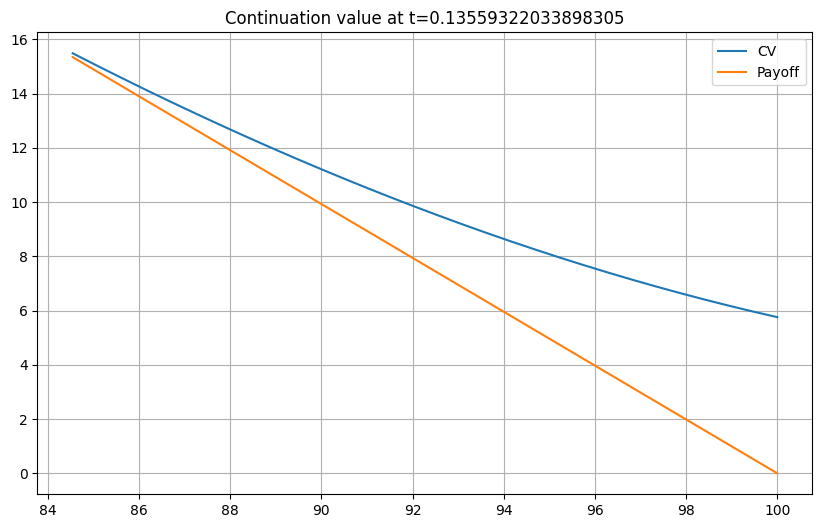

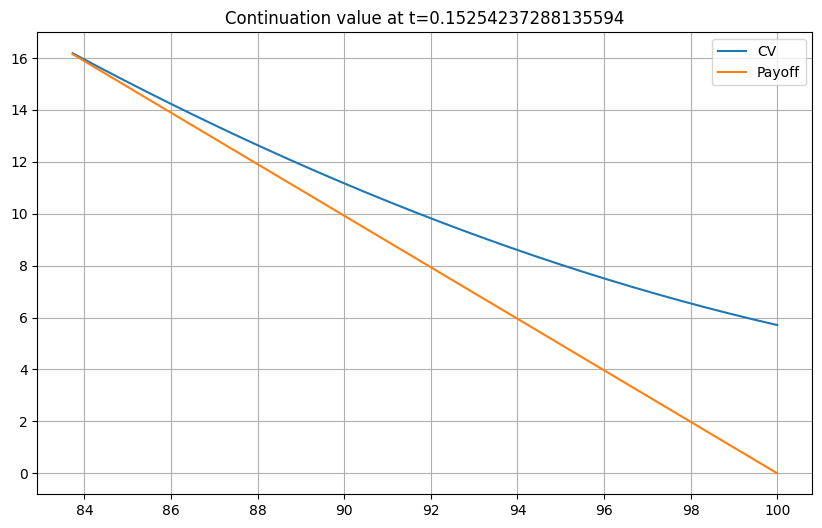

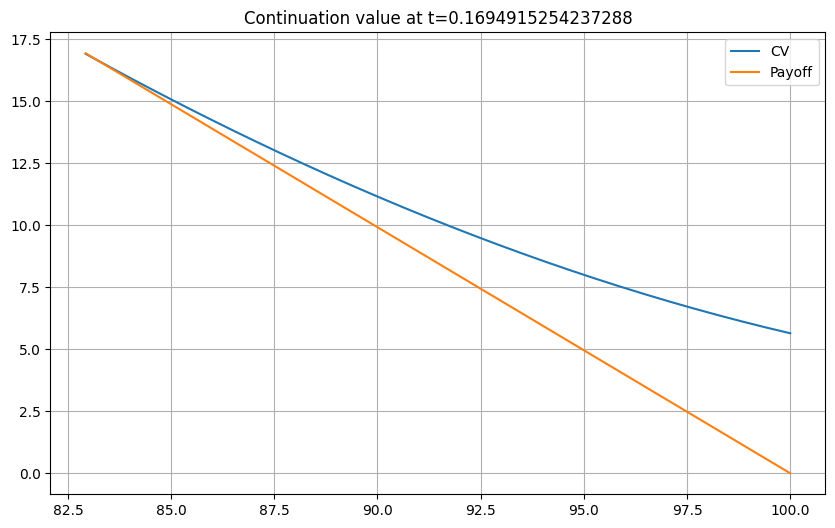

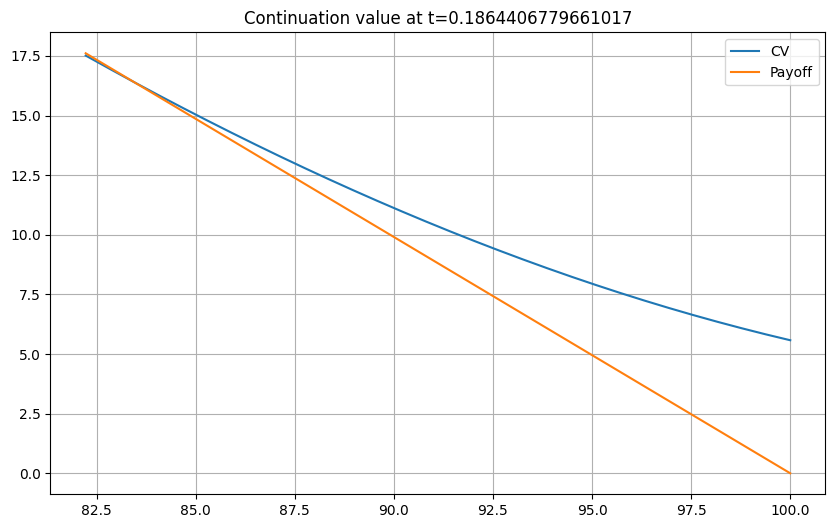

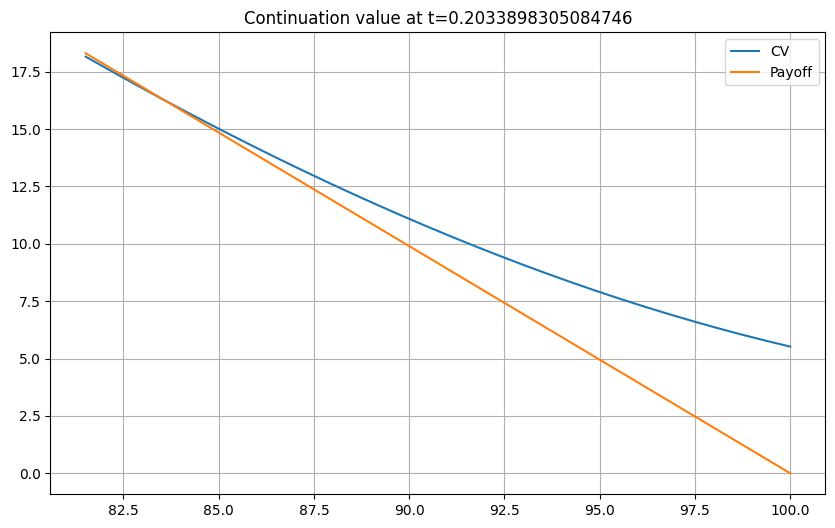

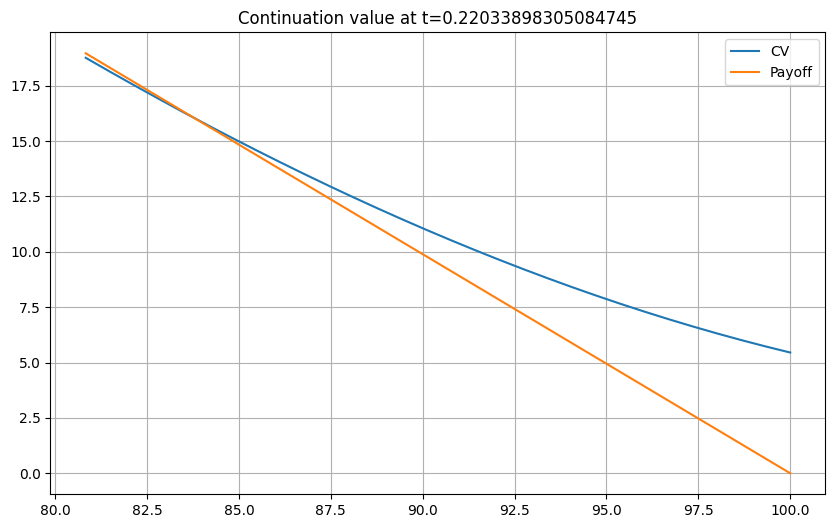

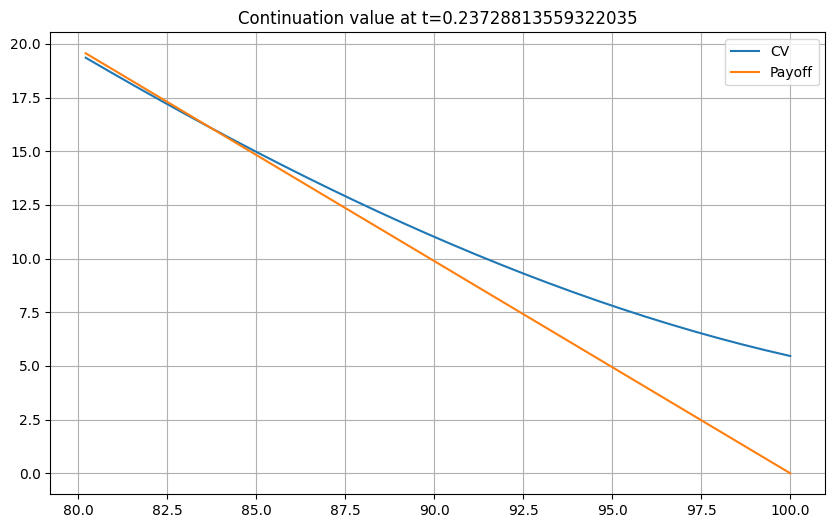

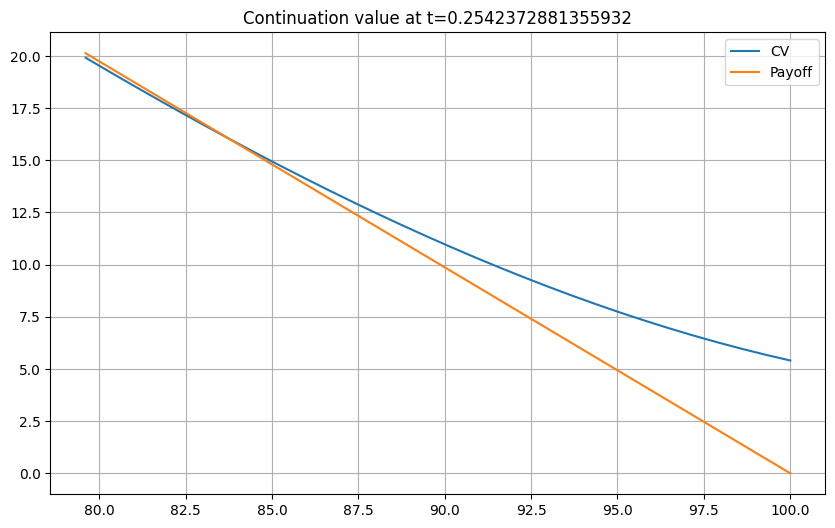

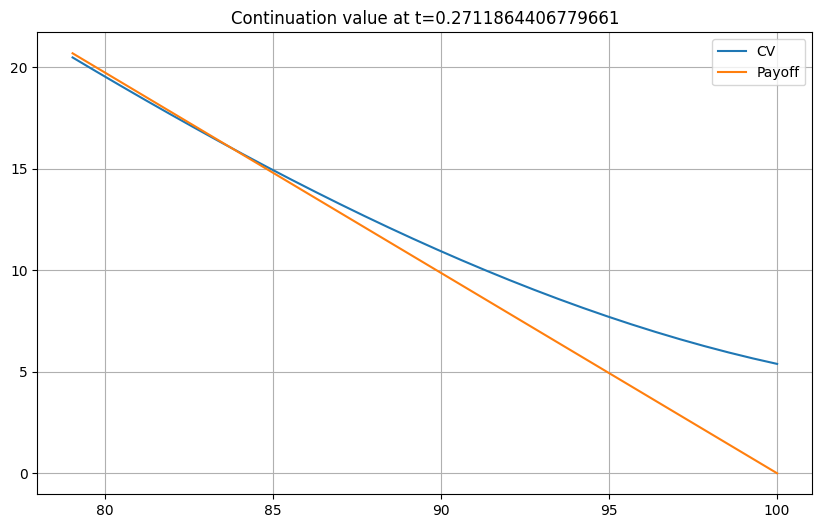

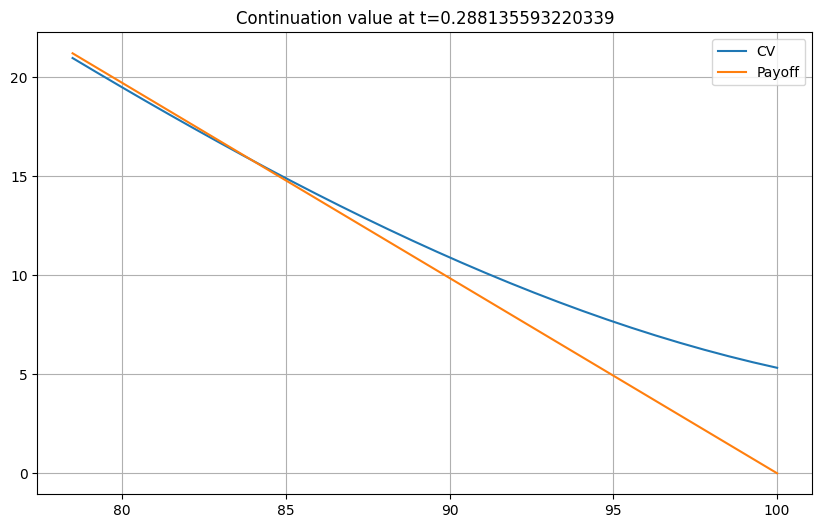

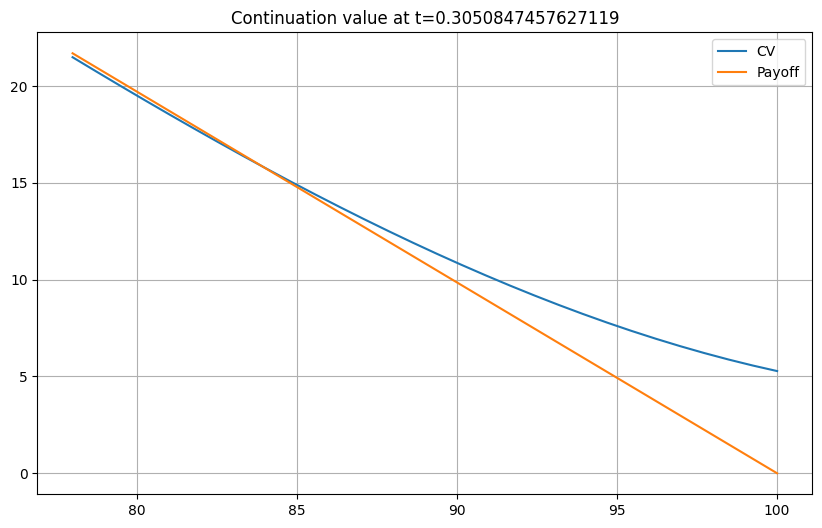

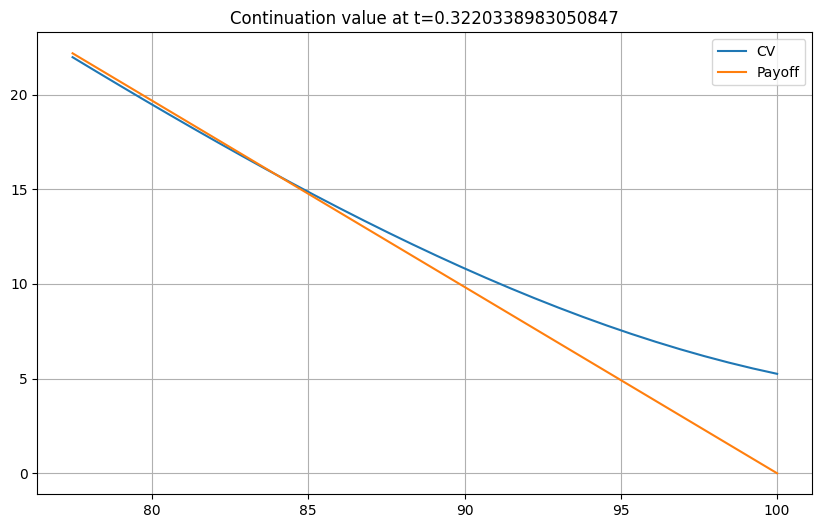

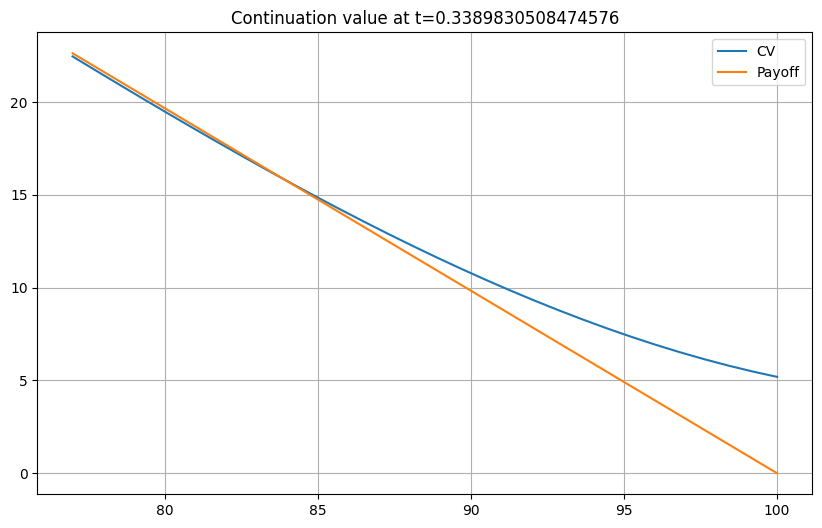

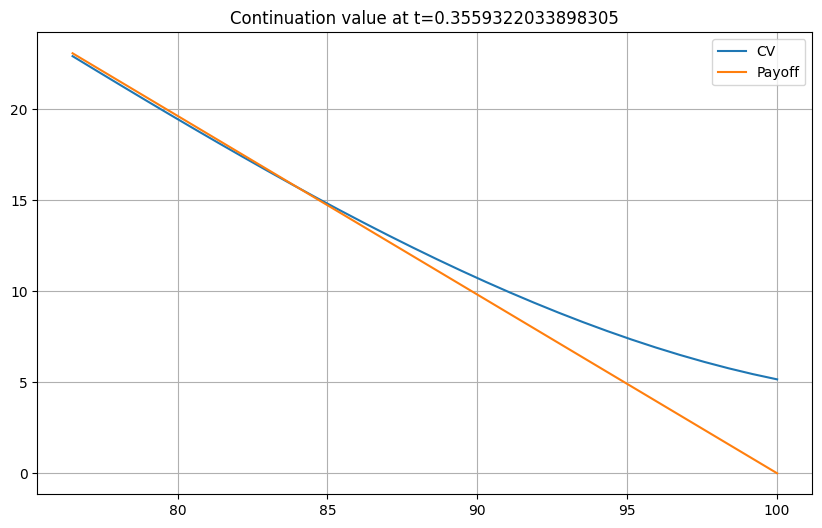

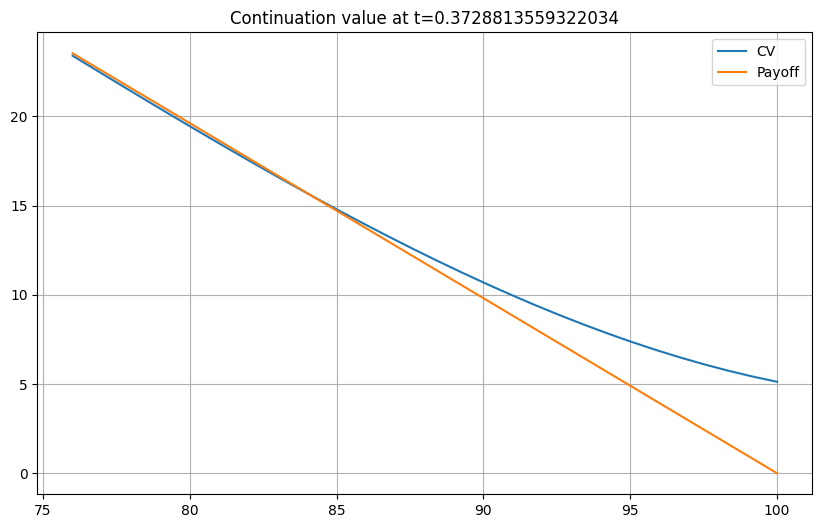

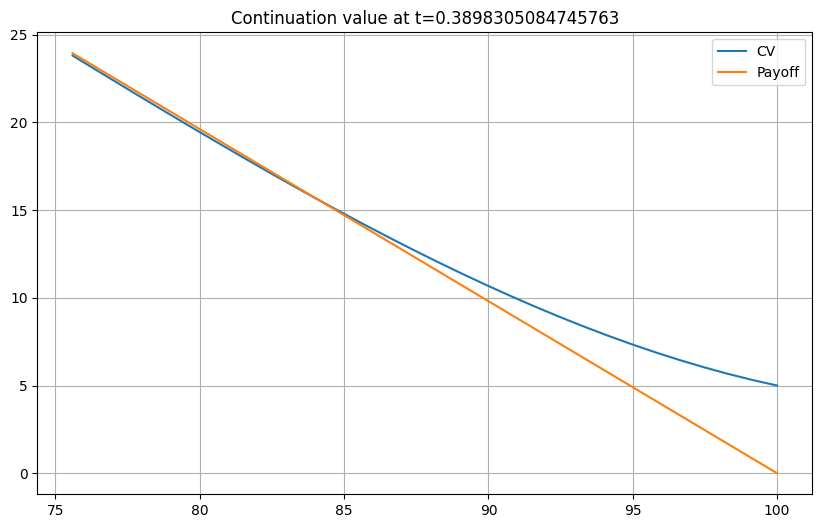

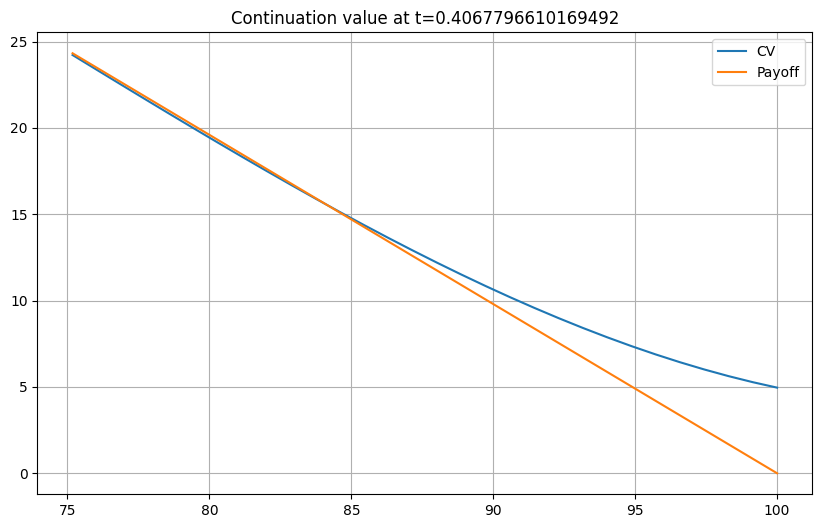

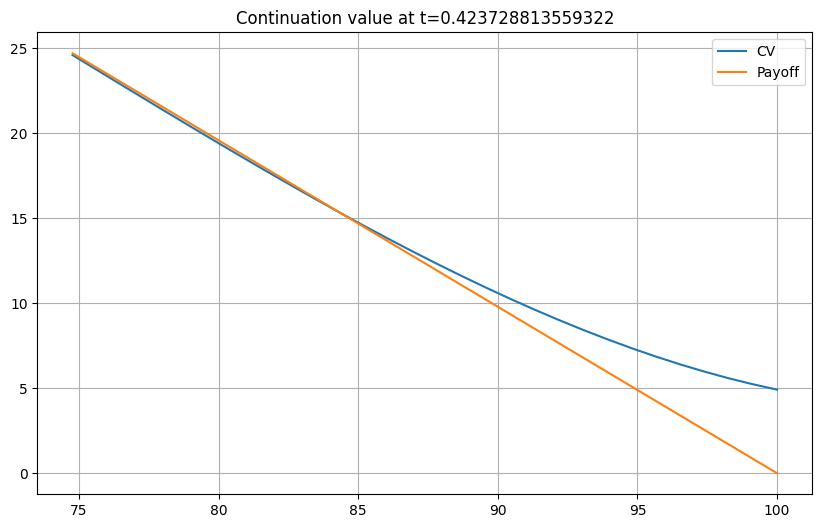

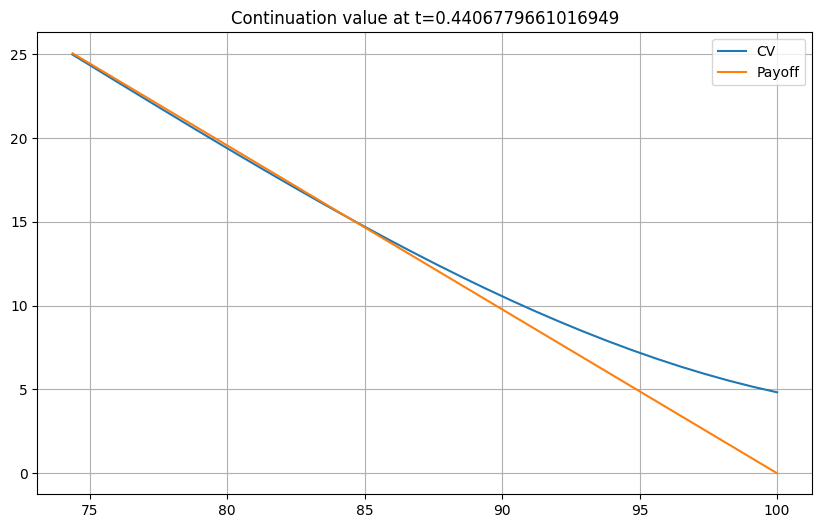

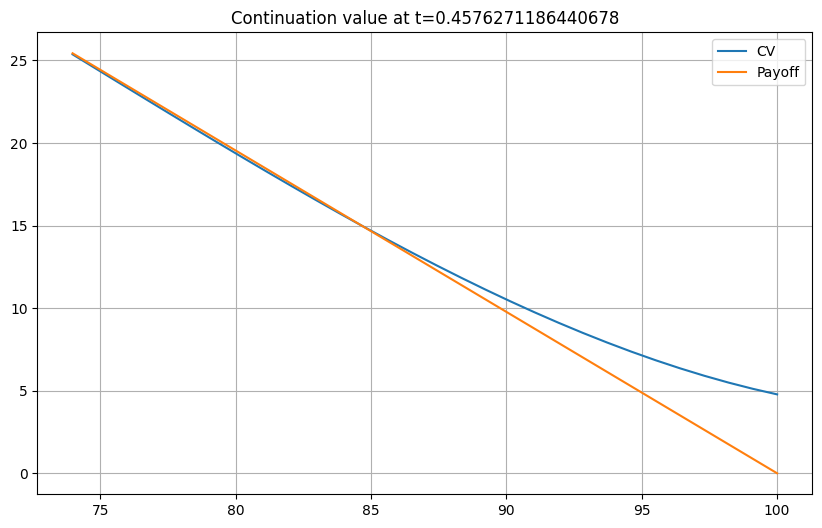

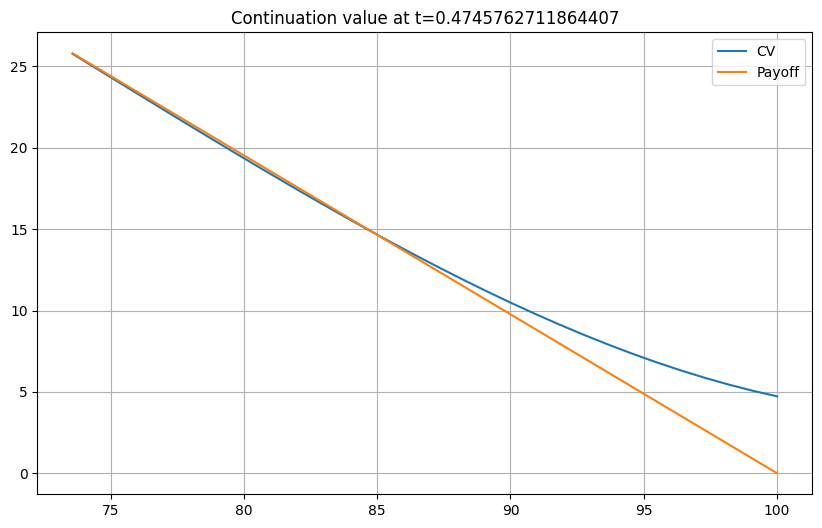

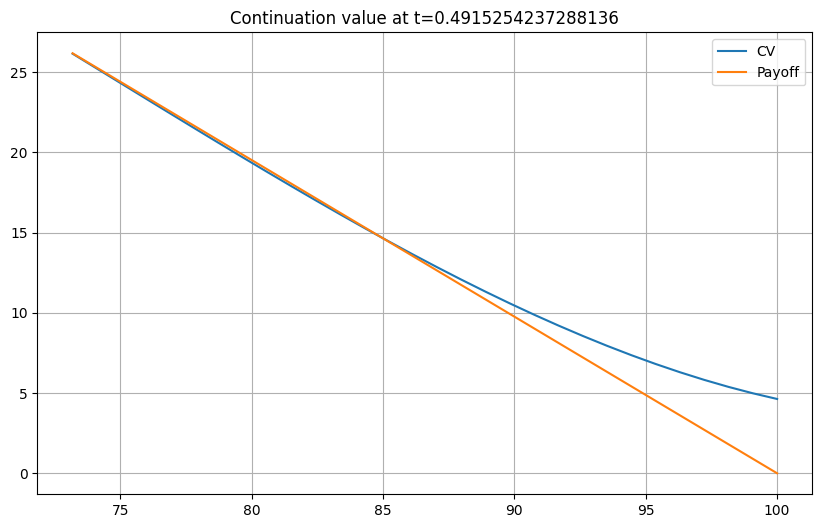

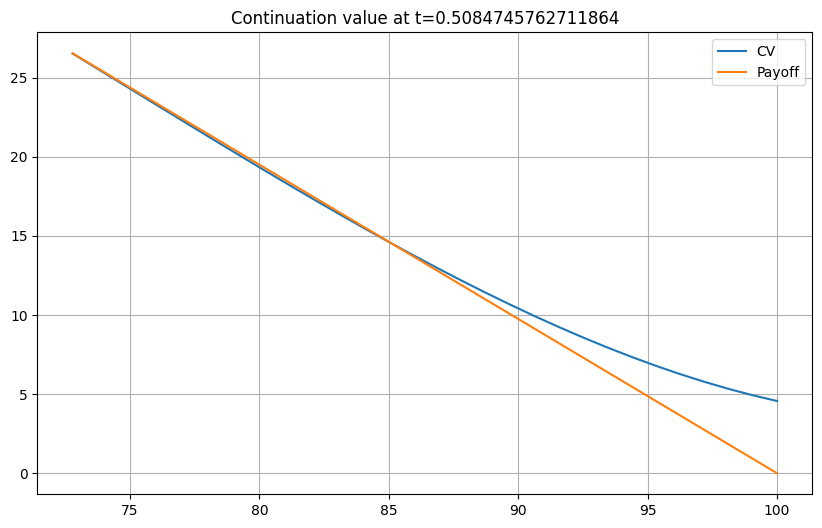

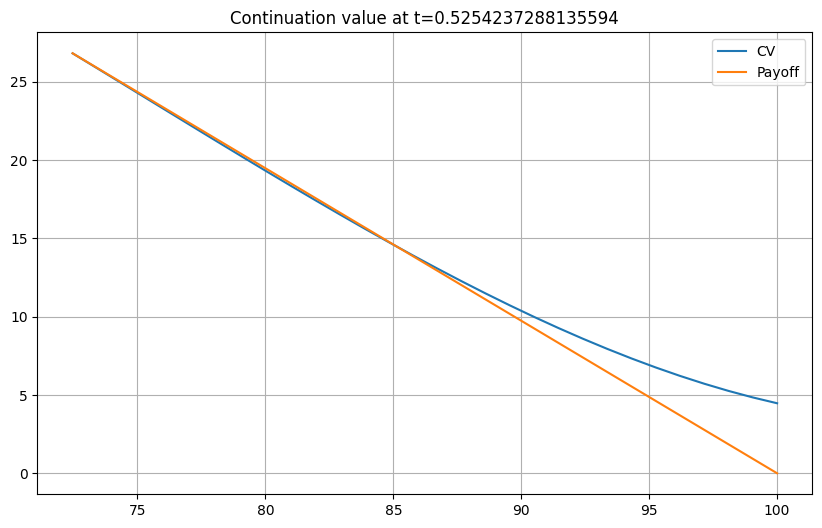

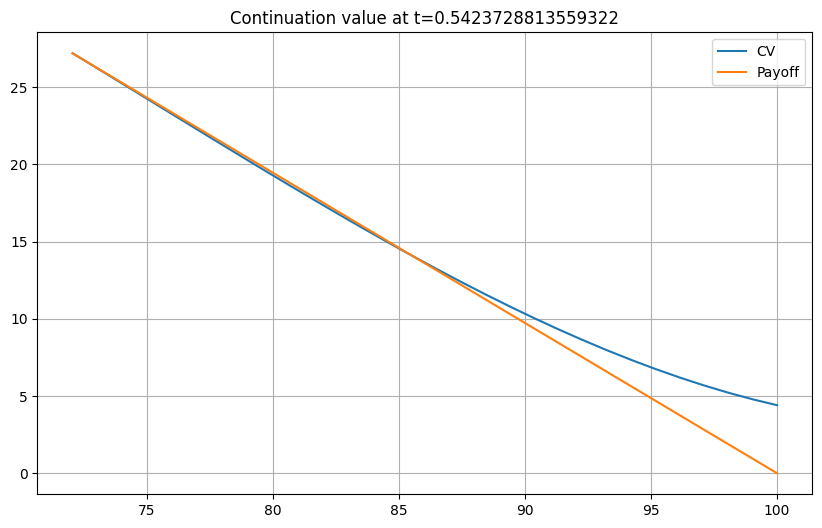

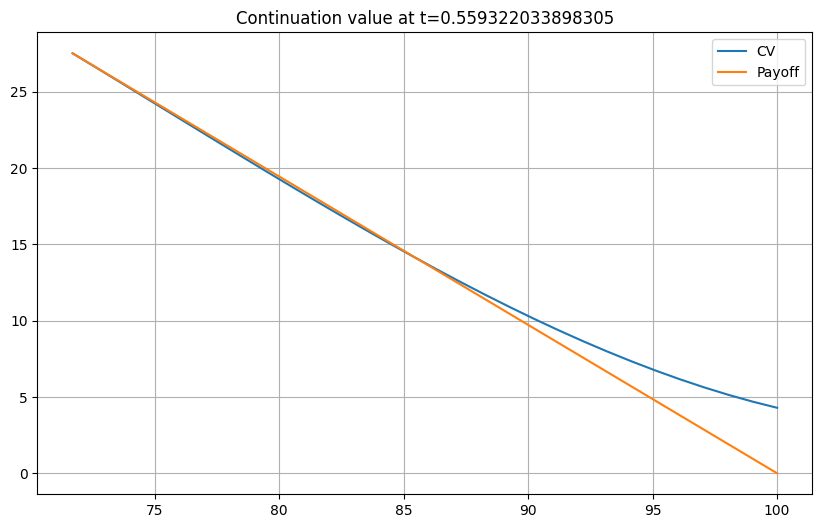

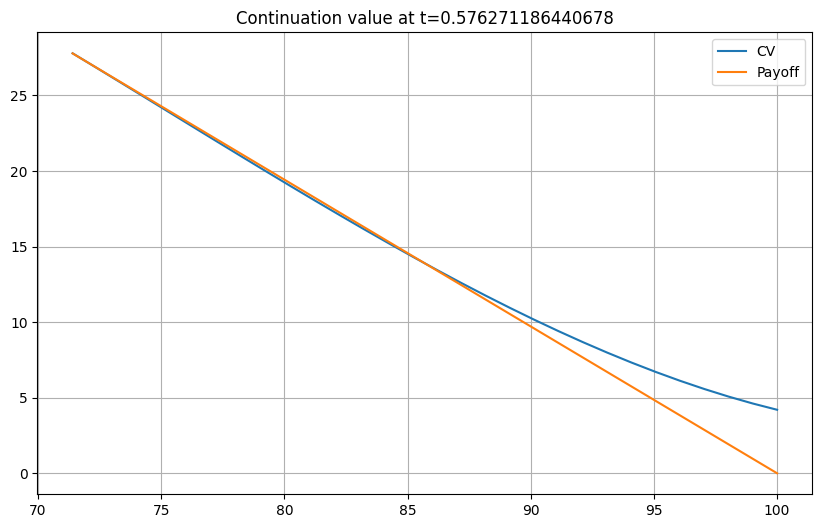

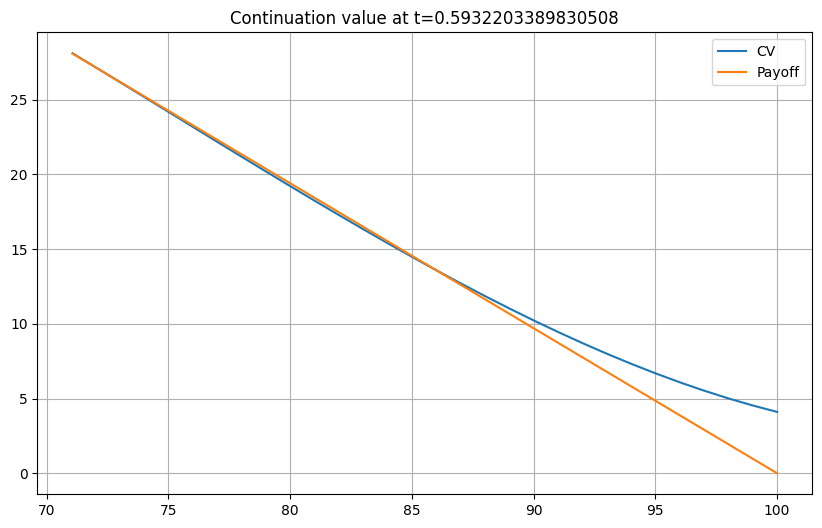

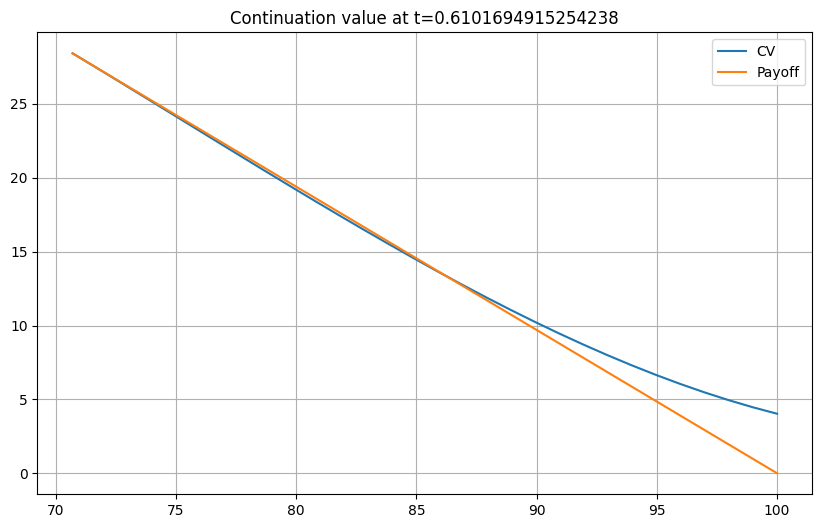

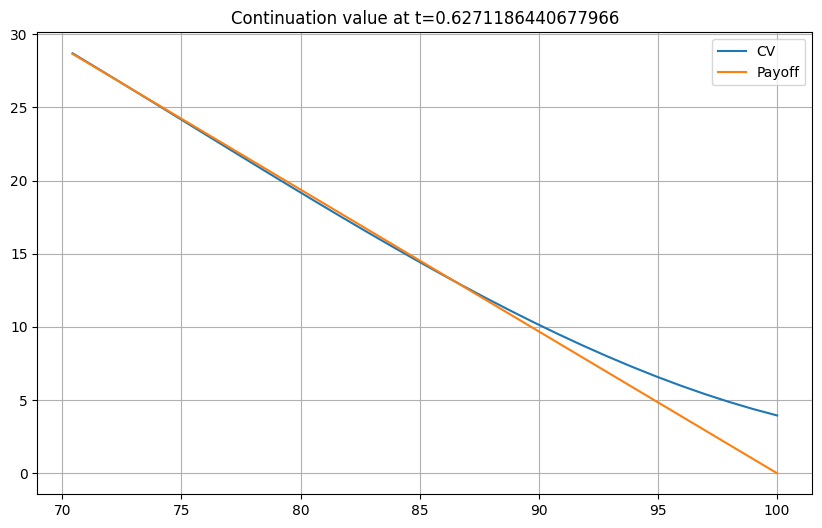

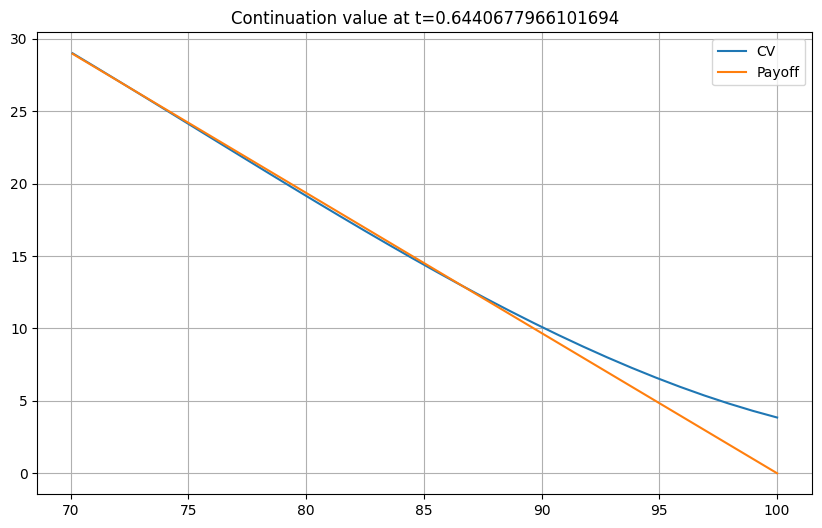

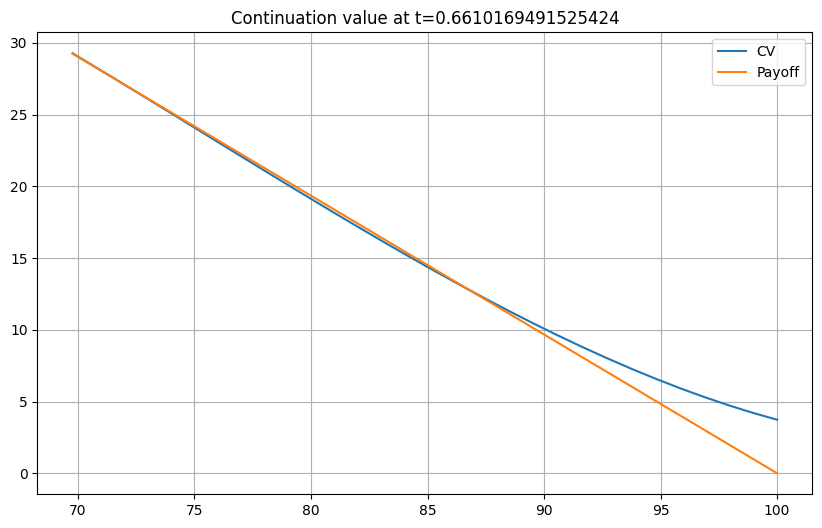

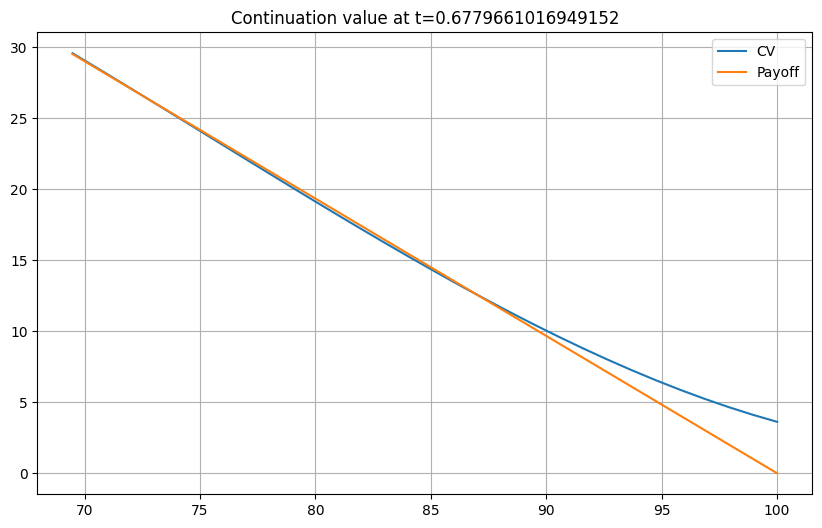

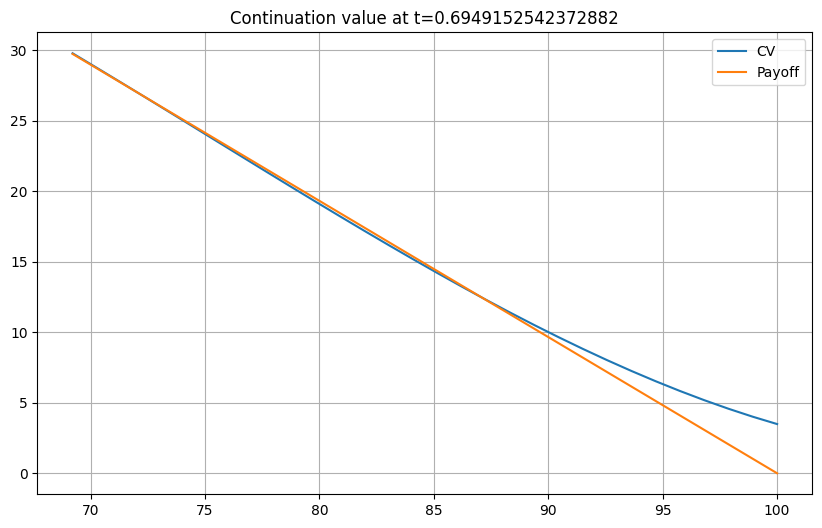

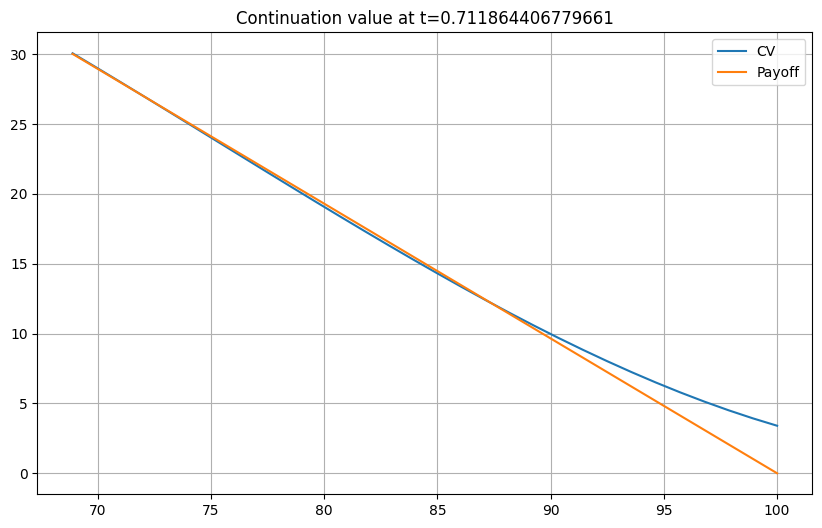

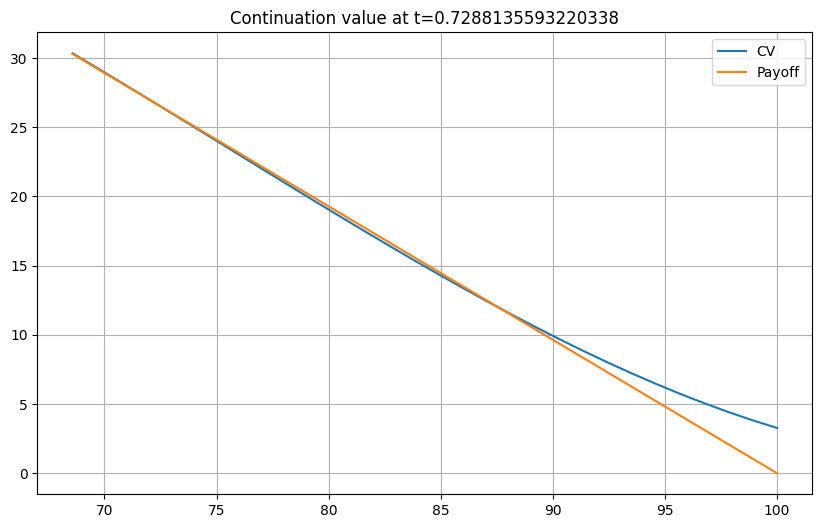

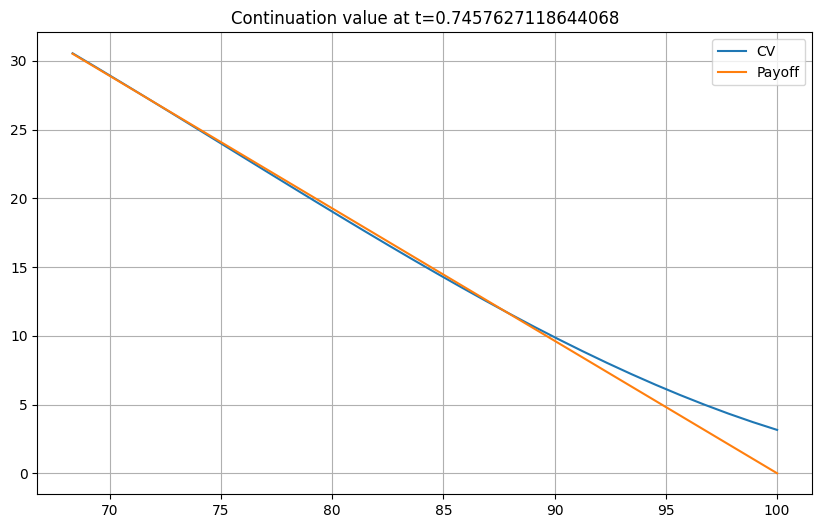

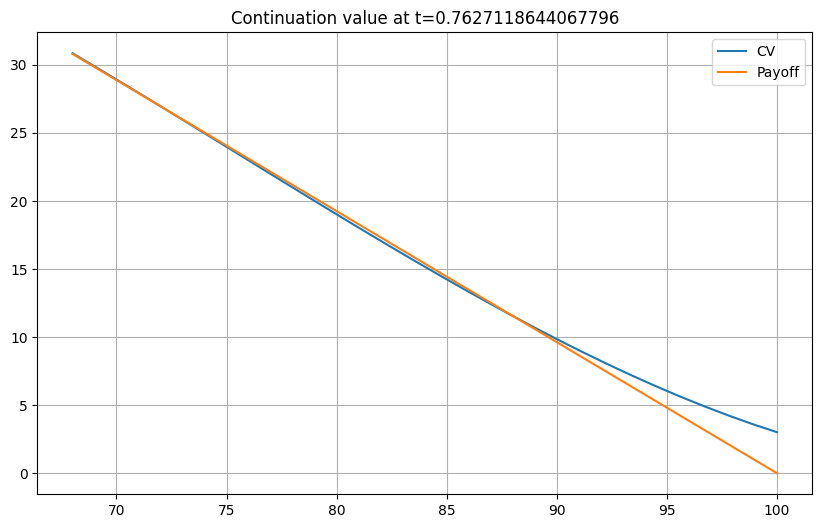

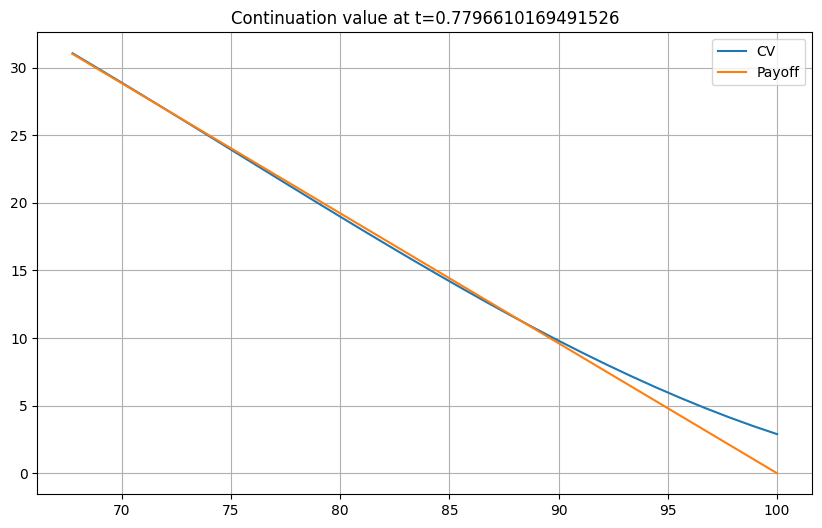

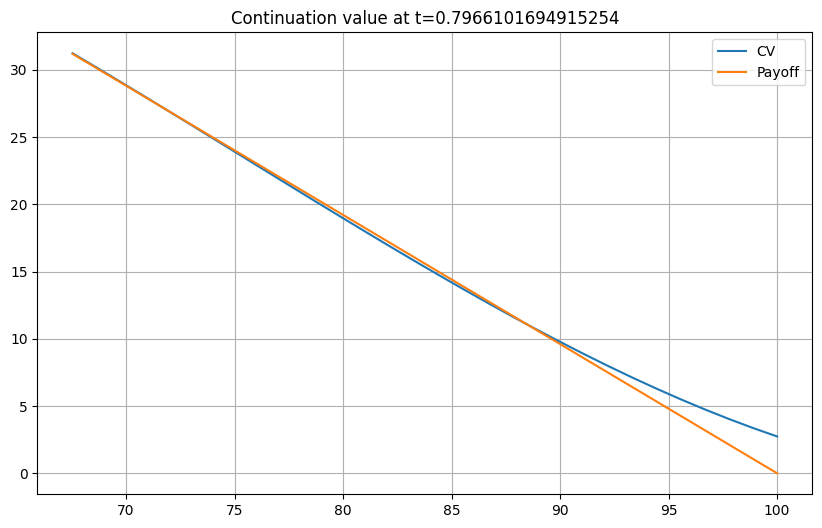

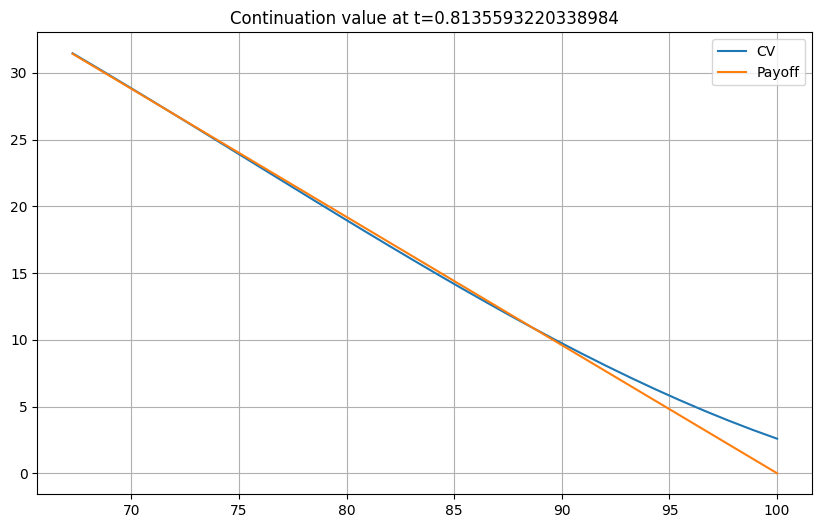

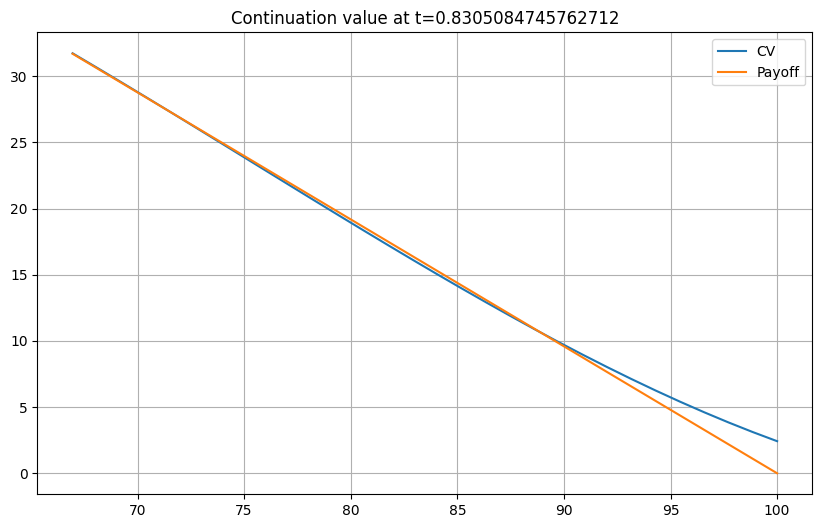

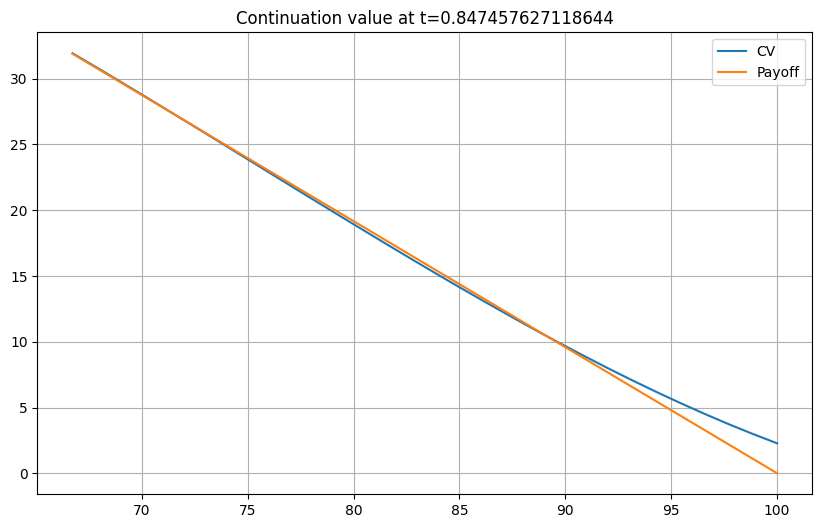

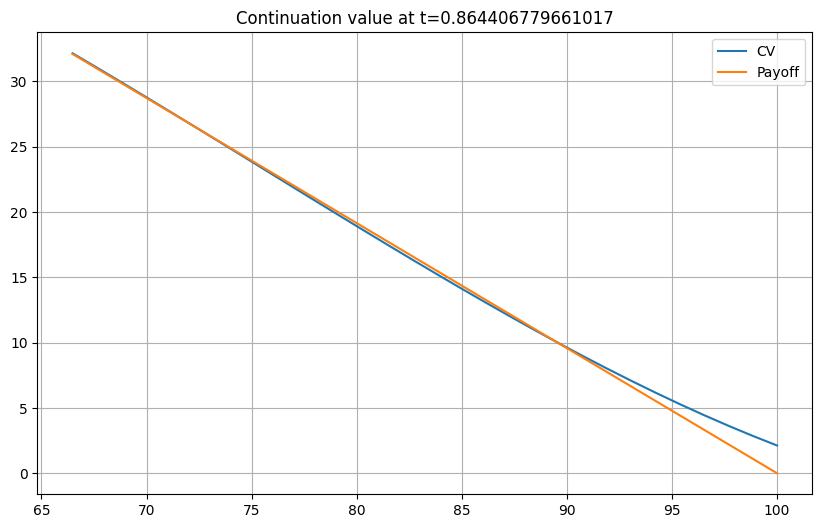

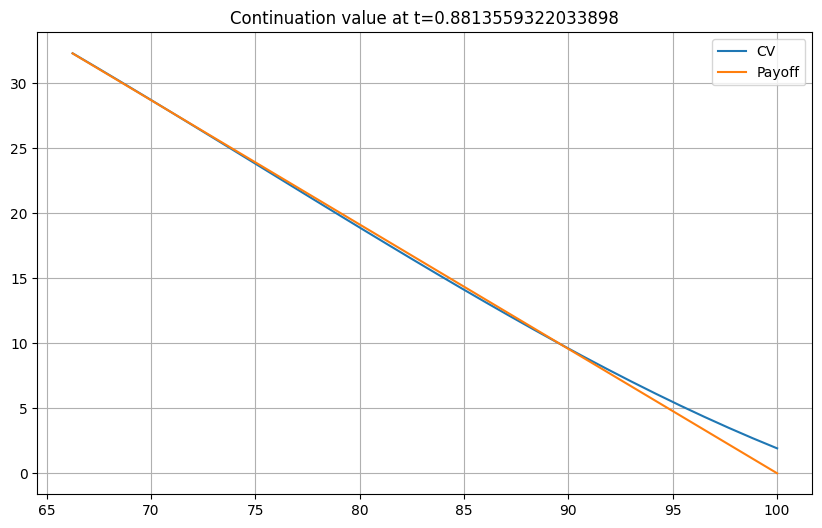

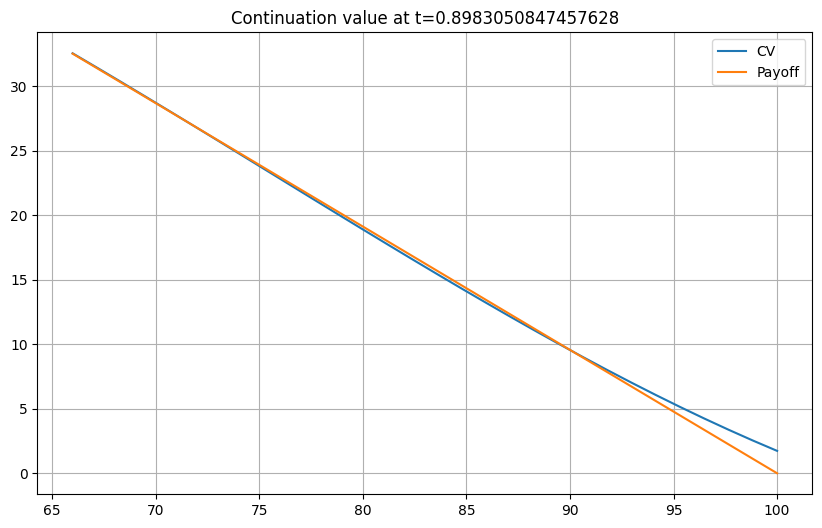

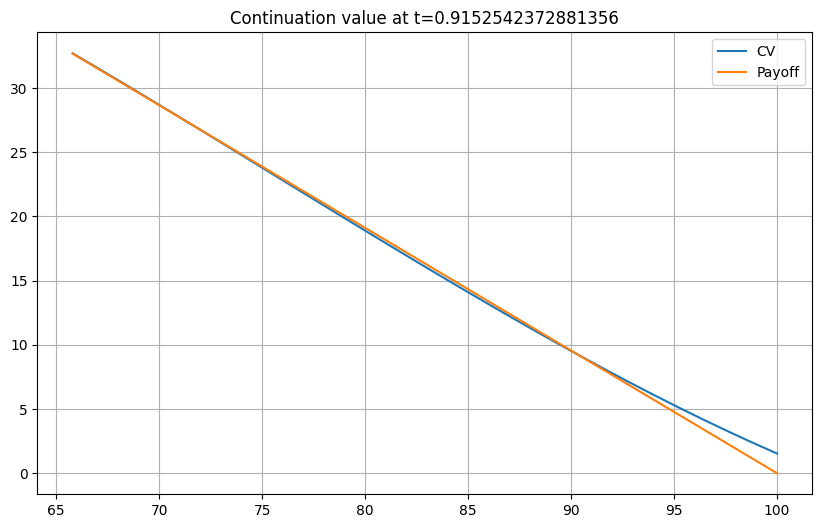

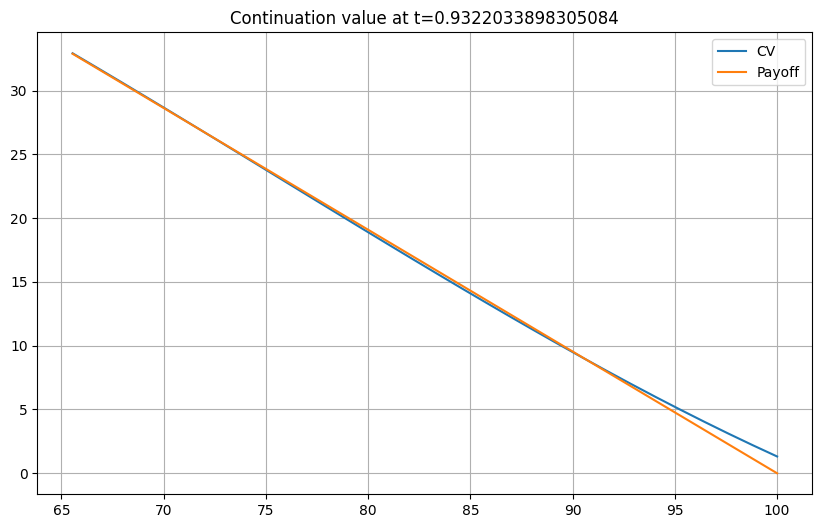

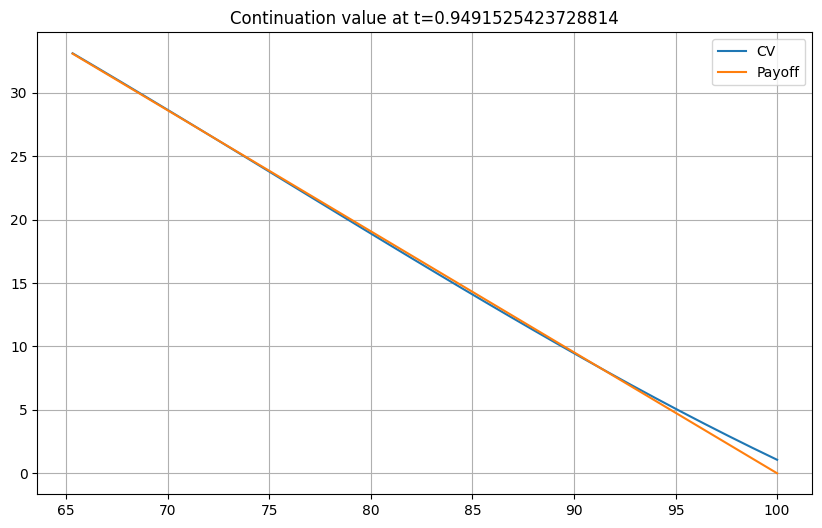

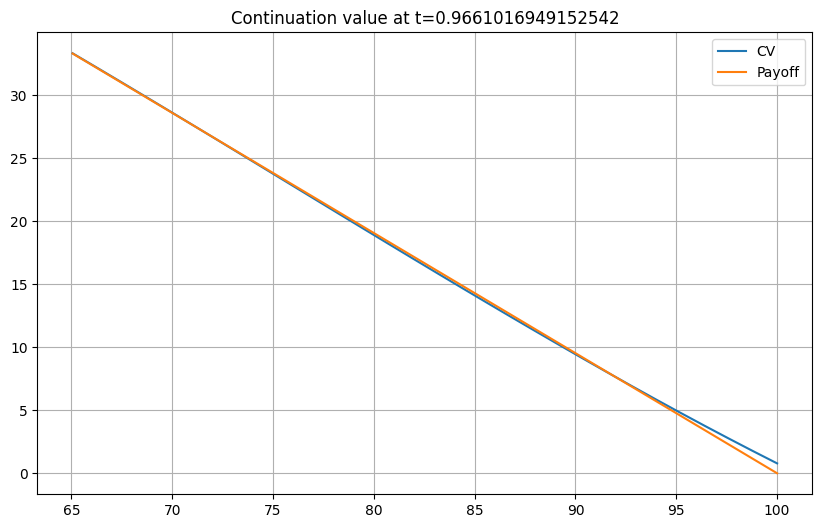

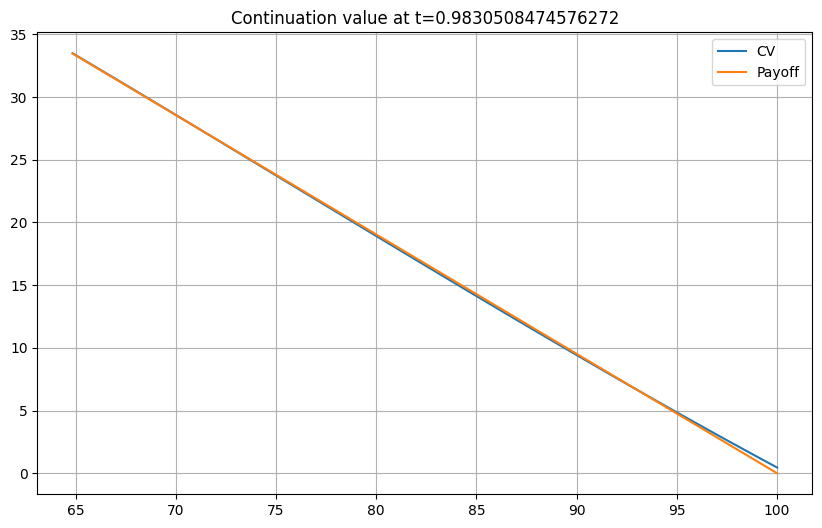

None


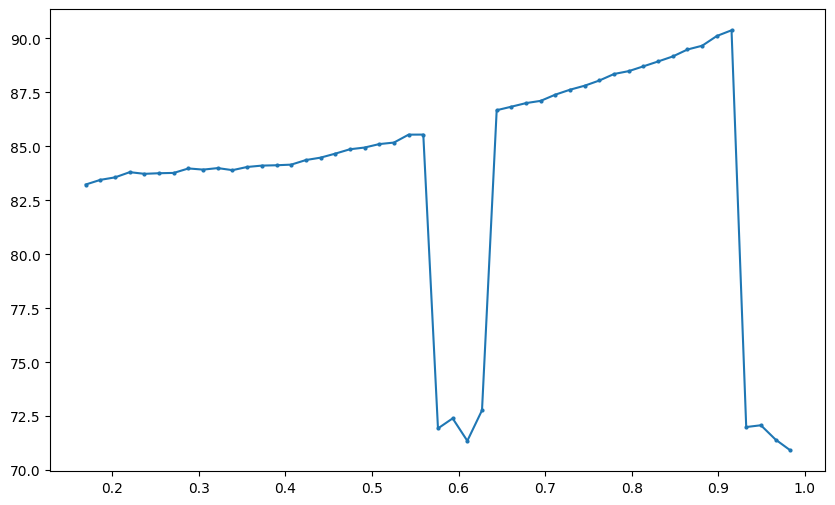

In [29]:
import scipy
exercise_boundary_lsmc = []
for i, t in tqdm(list(
    enumerate(sampler.time_grid)
)):
    if pricer.weights[i] is None:
        print("None")
        exercise_boundary_lsmc.append(None)
        continue

    func_to_find_root = lambda x: (
        sampler.discount_factor[0, i] * max(0, 100. - x) - 
        (
            pricer.basis_functions_transformer.transform(
                pricer.scalers[i].transform([[x]])
            ) @ pricer.weights[i]
        ).reshape(-1)[0]
    )

    root = scipy.optimize.minimize_scalar(
        lambda x: func_to_find_root(x)**2,
        bounds=[np.percentile(sampler.markov_state[:, i, 0], 0.99), 100]
    )["x"]
    
    if abs(func_to_find_root(root)) < 1e-6:
        exercise_boundary_lsmc.append(
            root
        )
    else:
        exercise_boundary_lsmc.append(
            None
        )

    payoff = np.vectorize(lambda x: sampler.discount_factor[0, i] * max(0, 100. - x))
    continuation_value = np.vectorize(lambda x: (
        pricer.basis_functions_transformer.transform(
            pricer.scalers[i].transform([[x]])
        ) @ pricer.weights[i]
    ).reshape(-1)[0])
    plt.figure(figsize=(10, 6))
    plt.title(f"Continuation value at t={t}")
    grid = np.linspace(np.percentile(sampler.markov_state[:, i, 0], 0.99), 100, 30)
    plt.plot(grid, continuation_value(grid), label="CV")
    plt.plot(grid, payoff(grid), label="Payoff")
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sampler.time_grid, exercise_boundary_lsmc, "-o", markersize=2)
plt.show()

In [28]:
exercise_boundary_lsmc

[None,
  message: Solution found.
  success: True
   status: 0
      fun: 9.351499938143602
        x: 94.15206732527608
      nit: 28
     nfev: 28,
  message: Solution found.
  success: True
   status: 0
      fun: 4.421363081816055
        x: 91.87569600394825
      nit: 29
     nfev: 29,
  message: Solution found.
  success: True
   status: 0
      fun: 2.129875667643737
        x: 90.17196020151515
      nit: 29
     nfev: 29,
  message: Solution found.
  success: True
   status: 0
      fun: 1.0707159867615128
        x: 88.75778497443147
      nit: 30
     nfev: 30,
  message: Solution found.
  success: True
   status: 0
      fun: 0.5059236075832285
        x: 87.53712115566474
      nit: 29
     nfev: 29,
  message: Solution found.
  success: True
   status: 0
      fun: 0.18750112347896353
        x: 86.43056746087784
      nit: 30
     nfev: 30,
  message: Solution found.
  success: True
   status: 0
      fun: 0.0815439778428088
        x: 85.43795098677828
      nit: 30
  

In [38]:
sampler.discount_factor[0, i]

TypeError: 'NoneType' object is not subscriptable

In [16]:
exercise_boundary_lsmc

[None,
 np.float64(44.299317064593055),
 np.float64(14.05908988710455),
 np.float64(99.9999921581193),
 np.float64(47.12138222936126),
 np.float64(41.49905417704007),
 np.float64(54.830064343063015),
 np.float64(45.67978188236729),
 np.float64(63.13257550599092),
 np.float64(46.09743094688778),
 np.float64(68.96885760064221),
 np.float64(65.8746483667493),
 np.float64(48.339029530714),
 np.float64(59.38208480721572),
 np.float64(44.53076871133335),
 np.float64(41.56946570878163),
 np.float64(44.96557861991123),
 np.float64(37.985958212083474),
 np.float64(35.85897706284445),
 np.float64(34.90777535467025),
 np.float64(35.92879365526234),
 np.float64(35.52690648250052),
 np.float64(35.00460202575592),
 np.float64(32.545668863369876),
 np.float64(28.698193698999685),
 np.float64(28.37327907555561),
 np.float64(28.796604628389698),
 np.float64(31.061027566820023),
 np.float64(29.1737111635752),
 np.float64(27.392654383020496),
 np.float64(29.349602894538464),
 np.float64(28.47337496226519

In [15]:
# import scipy
# exercise_boundary_lsmc = []
# for i, t in tqdm(list(enumerate(range(len(sampler.time_grid))))):
#     if pricer.weights[i] is None:
#         exercise_boundary_lsmc.append(None)
#         continue
#     exercise_boundary_lsmc.append(
#         scipy.optimize.minimize_scalar(
#             lambda x: (
#                 sampler.discount_factor[0, i] * max(0, 100. - x) - 
#                 (
#                     pricer.basis_functions_transformer.transform([[x]]) @ pricer.weights[i]
#                 ).reshape(-1)[0]
#             )**2,
#             bounds=[0, 100]
#         )["x"]
#     )

# plt.figure(figsize=(10, 6))
# plt.plot(sampler.time_grid, exercise_boundary_lsmc)
# plt.show()

In [49]:
pricer.weights

[None,
 array([ 6.41080074, -0.25016612,  0.00815643]),
 array([ 6.54789924e+00, -3.92305724e-01,  5.08024010e-03]),
 array([ 6.65315503, -0.48079655,  0.0098479 ]),
 array([ 6.74791805, -0.56348747,  0.01242452]),
 array([ 6.82903602, -0.62764831,  0.02032046]),
 array([ 6.89156295, -0.68967528,  0.02738318]),
 array([ 6.95937782, -0.75697438,  0.03011269]),
 array([ 7.0058797 , -0.78407766,  0.05618101]),
 array([ 7.06918785, -0.85576939,  0.05182659]),
 array([ 7.12952024, -0.91452259,  0.04998622]),
 array([ 7.18333119, -0.95862606,  0.05543113]),
 array([ 7.23502755, -1.00231424,  0.0568812 ]),
 array([ 7.28271439, -1.05484626,  0.0571631 ]),
 array([ 7.31795621, -1.09015887,  0.07017253]),
 array([ 7.36122434, -1.14165453,  0.0717924 ]),
 array([ 7.40275959, -1.16734   ,  0.07917517]),
 array([ 7.44305059, -1.21297651,  0.08088835]),
 array([ 7.48045161, -1.23868335,  0.09409036]),
 array([ 7.51963523, -1.28897047,  0.09010731]),
 array([ 7.55266754, -1.32104945,  0.09752497]),
 